In [1]:
#Loading Packages 

using Parameters
using QuantEcon
using Plots
using Format

### Problem 1 a)

In [2]:
# Defining Flow Utility Function

function u(c) 
    if c > 0
        return (c^(-1))/(-1) 
    else
        return -Inf
    end
end  




function update_bellman2!(p, V, policy, grids, EV)
    @unpack a_grid, y_grid = grids 
    @unpack r, β, μ, σ_ϵ, ρ         = p 

    
    # Loop over all the indices of V 
    for sub in CartesianIndices(V)
        # Unpack 
        ai, yi = sub[1], sub[2] 
        a = a_grid[ai]
        y = exp(y_grid[yi]) # transforming the income level from a log scale to a level scale.
        
        # Cash on hands
        z  = (1 + r) * a + y
        a′ = a_grid
        c  = z .- a′
        
        # Vectorized grid search 
        vmax, pol = @views findmax(u.(c) .+ β .* EV[:, yi])
        
        # Store the max values and policies
        V[sub]      = vmax
        policy[sub] = pol 
        
    end
    return 
end


function solve_vfi2!(p, a_grid, V0; tol = 1e-12, maxiter = 1000, debug=false)
    @unpack Ny, ρ, σ_ϵ = p
    V0      = copy(V0)
    V       = zeros(size(V0))
    policy  = zeros(Int, size(V0))
    errors  = Float64[]  
    iter    = 0

    # Discretize the income process
    mc      = rouwenhorst(Ny, ρ, σ_ϵ)
    P       = mc.p'
    y_grid   = mc.state_values
    
    grids   = (; a_grid, y_grid)
    while true
        iter += 1 
        
        # Step 1: Calculate Expectations
        EV = V0 * P

        # Step 2: Update Bellman Equation
        update_bellman2!(p, V, policy, grids, EV)
        
        # Step 3: Check for convergence 
        ϵ = maximum(abs.(V - V0))
        push!(errors, ϵ)

        if ϵ < tol || iter >= maxiter 
            break
        end
        V0 .= V
    end

    return (; V, policy, iter, errors, a_grid, y_grid, P)
end




solve_vfi2! (generic function with 1 method)

In [3]:
## Run the code 
# Setup parameters

Na = 500
Ny = 30

p = (
    β   = 0.95,   # Discount factor
    r   = 0.03,   # Interest rate
    μ   = 0.5,    # Mean of the shock
    ρ   = 0.8,    # Persistence of the shock
    σ   = 2.0,   # Coefficient of Relative Risk Aversion
    σ_ϵ = 0.1,  # Standard deviation of the shock
    Ny
)

V0     = zeros(Na, Ny)
a_grid  = LinRange(1e-9, 500, Na)

# Solve the model 
@time @views solution = solve_vfi2!(p, a_grid, V0)
@unpack V, policy, errors = solution 

 39.516848 seconds (10.72 M allocations: 32.278 GiB, 5.68% gc time, 2.54% compilation time)


(V = [-25.331099076945033 -24.8748647136717 … -17.284648295337846 -17.051836110987256; -23.572187861461888 -23.250884219437296 … -16.814320280996014 -16.593660853756546; … ; -1.1682034956852045 -1.1678310277613286 … -1.151053725576372 -1.1500628267108355; -1.1659957438089754 -1.1656245984214608 … -1.148911077397146 -1.147923157791402], policy = [1 1 … 2 2; 1 1 … 3 3; … ; 493 493 … 494 494; 494 494 … 495 495], iter = 541, errors = [2.4535291753168793, 1.9574583745261287, 1.6159500093675598, 1.3713471748968873, 1.1899534868022972, 1.0512161955583892, 0.9421267602262837, 0.8541835891777865, 0.781674424760805, 0.7206680300426367  …  1.5170087408478139e-12, 1.4388490399142029e-12, 1.3713474800169934e-12, 1.298516849601583e-12, 1.234568003383174e-12, 1.1759482276829658e-12, 1.1155520951433573e-12, 1.0622613899613498e-12, 1.0089706847793423e-12, 9.592326932761353e-13], a_grid = LinRange{Float64}(1.0e-9, 500.0, 500), y_grid = -0.8975274678557509:0.0618984460590173:0.8975274678557509, P = [0.04

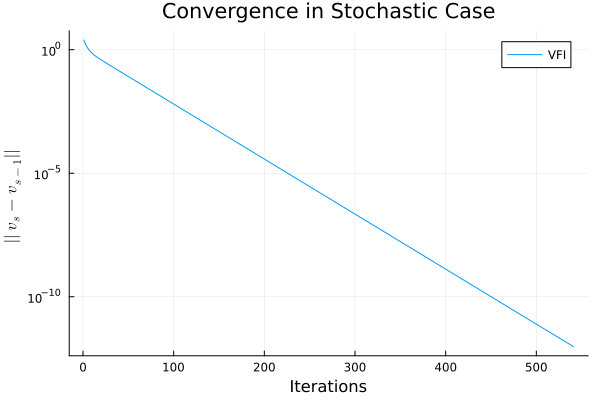

In [4]:
plot(1:length(errors), errors, 
    yscale = :log10,
    title  = "Convergence in Stochastic Case",
    xlabel = "Iterations",
    ylabel = raw"$||v_s - v_{s-1}||$",
    label  = "VFI",
    # yticks = 10.0.^(0:-2:-10)
)

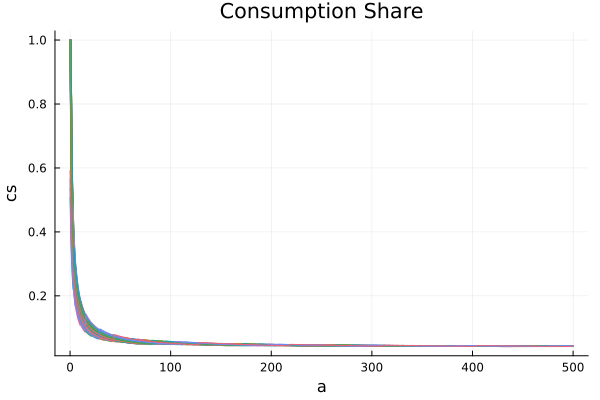

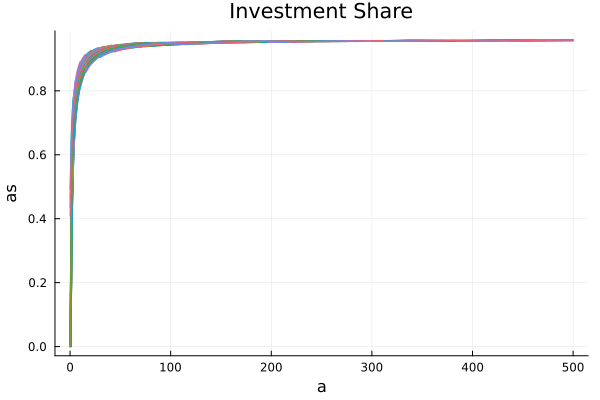

In [5]:
solution = solve_vfi2!(p, a_grid, V0)
@unpack r, β = p
@unpack a_grid, y_grid = solution
a′ = a_grid[solution.policy]
z  = (1 + r) .* a_grid .+ exp.(y_grid')
c  = z .- a′

# Consumption/investment share 
cs = c./z
as = a′./z

plot_consumption_share = plot(a_grid, cs, xlabel="a", ylabel="cs", title="Consumption Share", legend = false)
display(plot_consumption_share)
plot_investment_share = plot(a_grid, as, xlabel="a", ylabel="as", title="Investment Share", legend = false)
display(plot_investment_share)

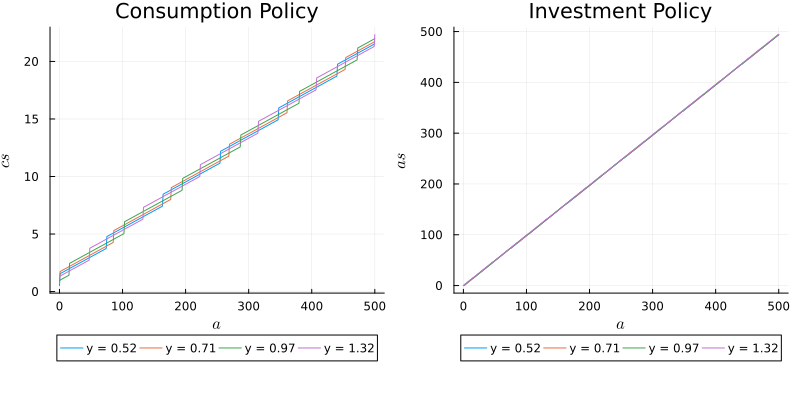

In [6]:
## Consumption policy for a variety of y values 
yVals = [5, 10, 15, 20]
p1 = plot(legend=:outerbottom, legend_column = -1)
for yi in yVals
    plot!(a_grid, c[:, yi], label = format("y = {:.2f}", exp(y_grid[yi])))
end
title!("Consumption Policy")
ylabel!(raw"$cs$")
xlabel!(raw"$a$")


## Next let's plot investment policy for the same y values
p2 = plot(legend=:outerbottom, legend_column = -1)
for yi in yVals
    plot!(a_grid, a′[:, yi] , label = format("y = {:.2f}", exp(y_grid[yi])))
end
title!("Investment Policy")
ylabel!(raw"$as$")
xlabel!(raw"$a$")



plt = plot(p1, p2, size = (800, 400), layout = (1, 2))

For a tolerance level of 1e-3, Res ≈ 0 for ∀ value of the asset grid higher than  : 30.06012024142084


┌ Info: Saved animation to /var/folders/yl/n488ndc55rg0z4z8qn79kxvr0000gn/T/jl_ZsRwHUDCdG.gif
└ @ Plots /Users/alessandroromano/.julia/packages/Plots/HyyIK/src/animation.jl:156


Plots.AnimatedGif("/var/folders/yl/n488ndc55rg0z4z8qn79kxvr0000gn/T/jl_ZsRwHUDCdG.gif")
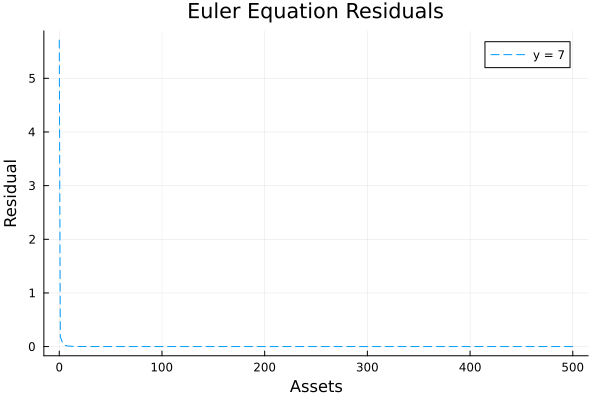

In [7]:
u′(c) = c^(-p.σ)

tolerance = 1e-3
res = zeros(size(a_grid, 1), size(y_grid, 1))
for (i, a) in enumerate(a_grid)
    for (j, y) in enumerate(y_grid)
        c = z[i, j]
        EV = 0.0
        for (jp, yjp) in enumerate(y_grid)
            c′ = z[findfirst(x -> x >= a′[i, jp], a_grid), jp]
            EV += u′(c′) * solution.P[j, jp]
        end
        res[i, j] = u′(c) - β * (1 + r) * EV
        
        if abs(res[i, j]) < tolerance
            res[i, j] = 0
        end
    end
end

zero_asset_indices = findall(res .== 0)

if isempty(zero_asset_indices)
    println("No such value found on the asset grid.")
else
    first_zero_asset_index = first(zero_asset_indices)
    first_zero_asset_value = a_grid[first_zero_asset_index]
    println("For a tolerance level of 1e-3, Res ≈ 0 for ∀ value of the asset grid higher than  : $first_zero_asset_value")
end

# Plot the residuals for representative values of y
yvals = collect(1:4) .* div(p.Ny, 4)
@gif for (j, y) in enumerate(yvals)
    plot_anim = plot(a_grid, res[:, j], label="y = $y", linestyle=:dash)
    xlabel!("Assets")
    ylabel!("Residual")
    title!("Euler Equation Residuals")  
end fps = 0.5

The Euler equation residual fluctuates around zero without ever reaching it before the end of the asset grid. 
